In [1]:
from hydra import initialize, compose
from hydra.utils import instantiate

import numpy as np
import torch
import matplotlib.pyplot as plt

import pytorch_lightning as pl
from pytorch_lightning.utilities import move_data_to_device

from bliss.global_env import GlobalEnv

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Configure encoder to make predictions using weights from a previous training run:

In [2]:
ckpt = "/data/scratch/descwl/checkpoints/encoder_wldgalaxy80_starmax100filtered_noise1_varypsf.ckpt"

# test data path in congif_descwl, make sure to change that each time !!!
with initialize(config_path="../", version_base=None):
    cfg = compose("config_descwl", {
        "train.pretrained_weights=" + ckpt,
        })

seed = pl.seed_everything(cfg.train.seed)
GlobalEnv.seed_in_this_program = seed

Seed set to 123123


Configure the test dataloader:

In [3]:
data_source = instantiate(cfg.train.data_source)
data_source.setup("test")
test_dl = data_source.test_dataloader()

Load in encoder weights:

In [4]:
encoder = instantiate(cfg.encoder).to(device)
encoder_state_dict = torch.load(cfg.train.pretrained_weights, map_location=device)["state_dict"]
encoder.load_state_dict(encoder_state_dict)
encoder = encoder.eval()

In [5]:
confidence_levels = torch.linspace(0.05, 0.95, steps = 19)

ci_quantiles = torch.distributions.Normal(0, 1).icdf(1 - (1 - confidence_levels)/2).to(device)

In [6]:
shear1_true = torch.zeros(len(test_dl), device='cpu')
shear2_true = torch.zeros(len(test_dl), device='cpu')

shear1_ci_lower = torch.zeros(len(test_dl), len(ci_quantiles), device='cpu')
shear1_ci_upper = torch.zeros(len(test_dl), len(ci_quantiles), device='cpu')
shear2_ci_lower = torch.zeros(len(test_dl), len(ci_quantiles), device='cpu')
shear2_ci_upper = torch.zeros(len(test_dl), len(ci_quantiles), device='cpu')

i = -1
for b in test_dl:
    i += 1
    batch = move_data_to_device(b, device)
    
    with torch.no_grad():
        shear1_true[i] = batch['tile_catalog']['shear_1'].squeeze().flatten()
        shear2_true[i] = batch['tile_catalog']['shear_2'].squeeze().flatten()
        
        input_lst = [inorm.get_input_tensor(batch) for inorm in encoder.image_normalizers]
        inputs = torch.cat(input_lst, dim=2)

        x_cat_marginal = encoder.net(inputs).squeeze()
        
        shear1_ci_lower[i] = x_cat_marginal[0] - ci_quantiles * x_cat_marginal[1].exp().sqrt()
        shear1_ci_upper[i] = x_cat_marginal[0] + ci_quantiles * x_cat_marginal[1].exp().sqrt()
        shear2_ci_lower[i] = x_cat_marginal[2] - ci_quantiles * x_cat_marginal[3].exp().sqrt()
        shear2_ci_upper[i] = x_cat_marginal[2] + ci_quantiles * x_cat_marginal[3].exp().sqrt()

In [7]:
shear1_coverage_probs = ((shear1_ci_lower <= shear1_true.unsqueeze(-1)) * (shear1_true.unsqueeze(-1) <= shear1_ci_upper)).float().mean(0)
shear2_coverage_probs = ((shear2_ci_lower <= shear2_true.unsqueeze(-1)) * (shear2_true.unsqueeze(-1) <= shear2_ci_upper)).float().mean(0)

In [8]:
for i, ci in enumerate(confidence_levels):
    print(f'Confidence level: {ci:.2f}, Shear 1: {shear1_coverage_probs[i]:.4f}, Shear 2: {shear2_coverage_probs[i]:.4f}')

Confidence level: 0.05, Shear 1: 0.0475, Shear 2: 0.0700
Confidence level: 0.10, Shear 1: 0.1400, Shear 2: 0.1350
Confidence level: 0.15, Shear 1: 0.2000, Shear 2: 0.2025
Confidence level: 0.20, Shear 1: 0.2650, Shear 2: 0.2550
Confidence level: 0.25, Shear 1: 0.3150, Shear 2: 0.3000
Confidence level: 0.30, Shear 1: 0.3500, Shear 2: 0.3575
Confidence level: 0.35, Shear 1: 0.4000, Shear 2: 0.3950
Confidence level: 0.40, Shear 1: 0.4450, Shear 2: 0.4475
Confidence level: 0.45, Shear 1: 0.5375, Shear 2: 0.5000
Confidence level: 0.50, Shear 1: 0.5825, Shear 2: 0.5450
Confidence level: 0.55, Shear 1: 0.6225, Shear 2: 0.5850
Confidence level: 0.60, Shear 1: 0.6600, Shear 2: 0.6250
Confidence level: 0.65, Shear 1: 0.7175, Shear 2: 0.6700
Confidence level: 0.70, Shear 1: 0.7625, Shear 2: 0.7125
Confidence level: 0.75, Shear 1: 0.7925, Shear 2: 0.7575
Confidence level: 0.80, Shear 1: 0.8300, Shear 2: 0.7925
Confidence level: 0.85, Shear 1: 0.8775, Shear 2: 0.8375
Confidence level: 0.90, Shear 1

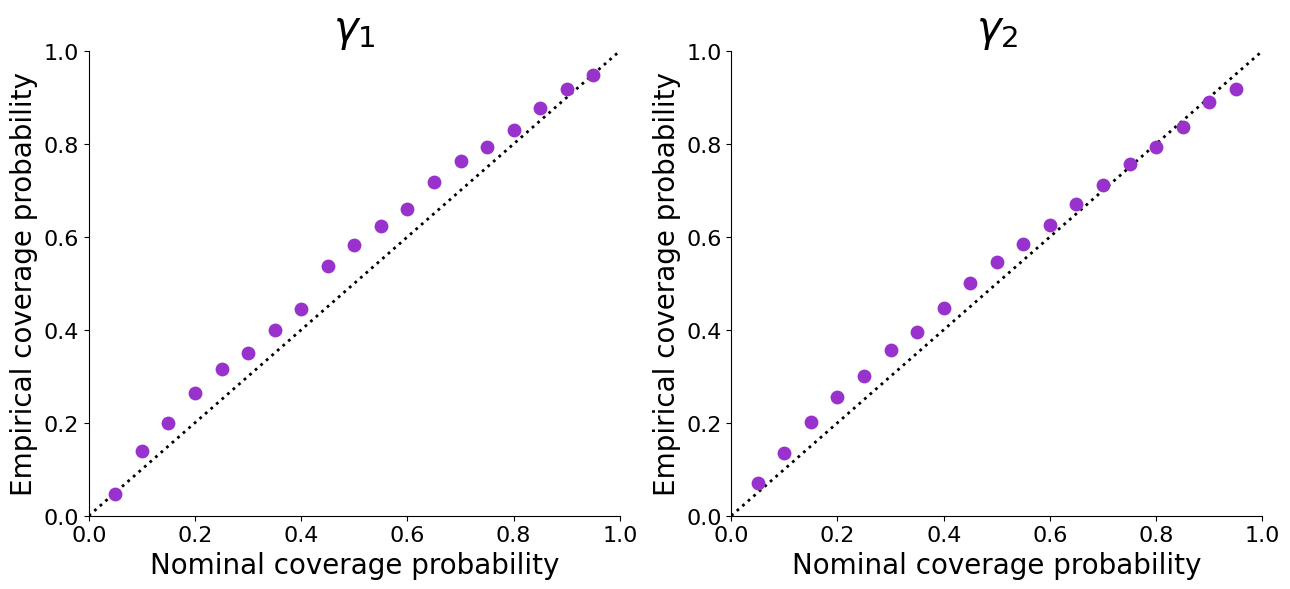

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(13, 6))
fontsize = 20
ticklabelsize = 16
color = 'darkorchid'
s = 80

_ = ax[0].axline((0,0), slope = 1, linestyle = 'dotted', color = 'black', linewidth=2, zorder=0)
_ = ax[0].scatter(confidence_levels, shear1_coverage_probs, color=color, s=s, zorder=1)
_ = ax[0].set_title('$\gamma_1$', fontsize=1.5*fontsize)
_ = ax[0].set_xlabel('Nominal coverage probability', fontsize = fontsize)
_ = ax[0].set_ylabel('Empirical coverage probability', fontsize = fontsize)
_ = ax[0].tick_params(axis='both', which='major', labelsize=ticklabelsize)
_ = ax[0].set_xlim(0, 1)
_ = ax[0].set_ylim(0, 1)

_ = ax[1].axline((0,0), slope = 1, linestyle = 'dotted', color = 'black', linewidth=2, zorder=0)
_ = ax[1].scatter(confidence_levels, shear2_coverage_probs, color=color, s=s, zorder=1)
_ = ax[1].set_title('$\gamma_2$', fontsize=1.5*fontsize)
_ = ax[1].set_xlabel('Nominal coverage probability', fontsize = fontsize)
_ = ax[1].set_ylabel('Empirical coverage probability', fontsize = fontsize)
_ = ax[1].tick_params(axis='both', which='major', labelsize=ticklabelsize)
_ = ax[1].set_xlim(0, 1)
_ = ax[1].set_ylim(0, 1)

for a in ax.flat:
    _ = a.spines[['top', 'right']].set_visible(False)

fig.tight_layout()

fig.savefig(f"figures/descwl_coverageprobs.png", dpi = 300, transparent = True, bbox_inches = 'tight', pad_inches = 0)

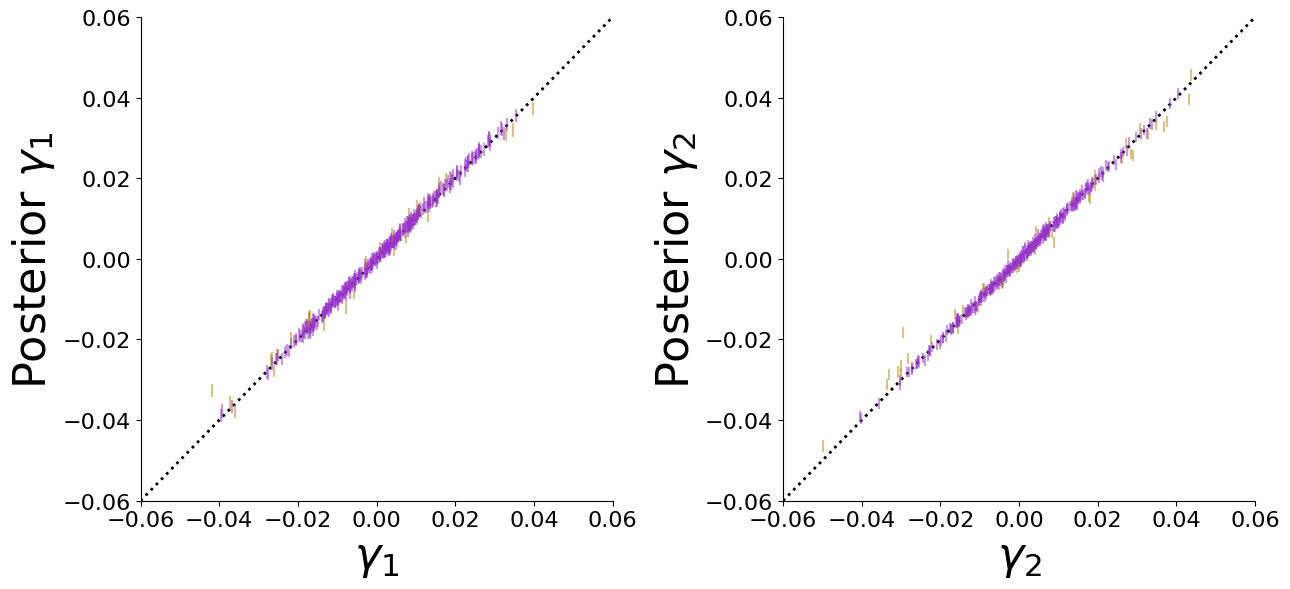

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(13,6))
fontsize = 32
ticklabelsize = 16
color = np.array(['darkgoldenrod','darkorchid'])
alpha = 0.5

axmin = -0.06
axmax = 0.06

np.random.seed(0)
indexes = np.arange(len(test_dl))

interval_idx = 17 # 90% credible interval

_ = ax[0].axline((0,0), slope = 1, linestyle = 'dotted', color = 'black', linewidth=2)
shear1_coverage = (
    ((shear1_ci_lower <= shear1_true.unsqueeze(-1)
        ) * (shear1_true.unsqueeze(-1) <= shear1_ci_upper))[...,interval_idx]
    )

covered_legend = False
uncovered_legend = False

for i in range(len(test_dl)):
    if (shear1_coverage[indexes[i]]) and (not covered_legend):
        covered_legend = True
        _ = ax[0].vlines(x = shear1_true[indexes[i]],
                        ymin = shear1_ci_lower[...,interval_idx][indexes[i]],
                        ymax = shear1_ci_upper[...,interval_idx][indexes[i]],
                        alpha = alpha, color = color[shear1_coverage[indexes[i]]],
                        label = f"covers ({round(100 * shear1_coverage_probs[interval_idx].item(), 1)}%)")
    elif (not shear1_coverage[indexes[i]]) and (not uncovered_legend):
        uncovered_legend = True
        _ = ax[0].vlines(x = shear1_true[indexes[i]],
                        ymin = shear1_ci_lower[...,interval_idx][indexes[i]],
                        ymax = shear1_ci_upper[...,interval_idx][indexes[i]],
                        alpha = alpha, color = color[shear1_coverage[indexes[i]]],
                        label = f"does not cover ({round(100 * (1 - shear1_coverage_probs[interval_idx].item()), 1)}%)")
    else:
        _ = ax[0].vlines(x = shear1_true[indexes[i]],
                        ymin = shear1_ci_lower[...,interval_idx][indexes[i]],
                        ymax = shear1_ci_upper[...,interval_idx][indexes[i]],
                        alpha = alpha, color = color[shear1_coverage[indexes[i]]])
_ = ax[0].set_xlabel('$\gamma_1$', fontsize=fontsize)
_ = ax[0].set_ylabel(r'Posterior $\gamma_1$', fontsize=fontsize)
_ = ax[0].tick_params(axis='both', which='major', labelsize=ticklabelsize)
# _ = ax[0].legend(loc = 'upper left', prop = {'size': ticklabelsize})
_ = ax[0].set_xlim(axmin, axmax)
_ = ax[0].set_ylim(axmin, axmax)



_ = ax[1].axline((0,0), slope = 1, linestyle = 'dotted', color = 'black', linewidth=2)
shear2_coverage = (
    ((shear2_ci_lower <= shear2_true.unsqueeze(-1)
        ) * (shear2_true.unsqueeze(-1) <= shear2_ci_upper))[...,interval_idx]
    )

covered_legend = False
uncovered_legend = False

for i in range(len(indexes)):
    if (shear2_coverage[indexes[i]]) and (not covered_legend):
        covered_legend = True
        _ = ax[1].vlines(x = shear2_true[indexes[i]],
                        ymin = shear2_ci_lower[...,interval_idx][indexes[i]],
                        ymax = shear2_ci_upper[...,interval_idx][indexes[i]],
                        alpha = alpha, color = color[shear2_coverage[indexes[i]]],
                        label = f"covers ({round(100 * shear2_coverage_probs[interval_idx].item(), 1)}%)")
    elif (not shear2_coverage[indexes[i]]) and (not uncovered_legend):
        uncovered_legend = True
        _ = ax[1].vlines(x = shear2_true[indexes[i]],
                        ymin = shear2_ci_lower[...,interval_idx][indexes[i]],
                        ymax = shear2_ci_upper[...,interval_idx][indexes[i]],
                        alpha = alpha, color = color[shear2_coverage[indexes[i]]],
                        label = f"does not cover ({round(100 * (1 - shear2_coverage_probs[interval_idx].item()), 1)}%)")
    else:
        _ = ax[1].vlines(x = shear2_true[indexes[i]],
                        ymin = shear2_ci_lower[...,interval_idx][indexes[i]],
                        ymax = shear2_ci_upper[...,interval_idx][indexes[i]],
                        alpha = alpha, color = color[shear2_coverage[indexes[i]]])
_ = ax[1].set_xlabel('$\gamma_2$', fontsize=fontsize)
_ = ax[1].set_ylabel(r'Posterior $\gamma_2$', fontsize=fontsize)
_ = ax[1].tick_params(axis='both', which='major', labelsize=ticklabelsize)
# _ = ax[1].legend(loc = 'upper left', prop = {'size': ticklabelsize})
_ = ax[1].set_xlim(axmin, axmax)
_ = ax[1].set_ylim(axmin, axmax)

for a in ax.flat:
    _ = a.spines[['top', 'right']].set_visible(False)

_ = fig.tight_layout()

fig.savefig(f"figures/descwl_credibleintervals.png", dpi = 300, transparent = True, bbox_inches = 'tight', pad_inches = 0)